In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.nn as nn

from torch.utils.data import DataLoader

#number of classes in dataset
NUM_CLASSES = 10

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

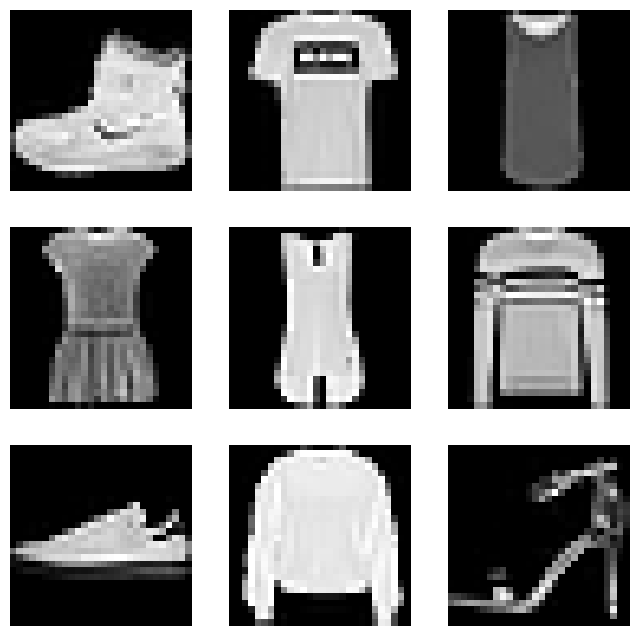

In [3]:
# plot the first few images
import matplotlib.pyplot as plt

def print_first_n_images(train_dataset, n):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(n):
        image, label = train_dataset[i]
        ax = axes[i // 3, i % 3]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

print_first_n_images(train_dataset, n=9)

In [4]:
# optimal hyperparameters:
# batch_size = 64
# fully connected layer size = 512
# activation function = PReLU

from utils_mixup import load_dataset, prep_pixels, define_model
from tqdm import tqdm
from torch import optim
import datetime

train_loader, test_loader = load_dataset(train_dataset, test_dataset, batch_size=64)
train_loader, test_loader = prep_pixels(train_loader, test_loader)

model = define_model(fc_layer_size=512, activation_fn=nn.PReLU())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

accuracies = []

best_accuracy = 0.0
patience_counter = 0

#include cutmix and mixup
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

start_time = datetime.datetime.now()
for epoch in range(20):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (images, labels) in pbar:
        #cutmix command
        images, labels = cutmix_or_mixup(images, labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            pbar.set_description(f'Epoch [{epoch + 1}/{20}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar_test = tqdm(test_loader)
        for images, labels in pbar_test:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar_test.set_description(f'Accuracy: {100 * correct / total:.2f}%')

        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0

        else:
            patience_counter += 1
            if patience_counter >= 3:
                print(f'Early stopping at epoch {epoch + 1}')
                break

end_time = datetime.datetime.now()
print(f'Final accuracy: {best_accuracy:.2f}%')
print(f'Training time: {end_time - start_time}')


Epoch [1/20], Step [800/938], Loss: 1.279893398284912: 100%|██████████| 938/938 [00:15<00:00, 59.03it/s]  
Accuracy: 85.84%: 100%|██████████| 157/157 [00:01<00:00, 119.23it/s]
Epoch [2/20], Step [800/938], Loss: 1.0176351070404053: 100%|██████████| 938/938 [00:16<00:00, 57.54it/s]
Accuracy: 87.23%: 100%|██████████| 157/157 [00:01<00:00, 118.79it/s]
Epoch [3/20], Step [800/938], Loss: 0.6877646446228027: 100%|██████████| 938/938 [00:16<00:00, 55.53it/s]
Accuracy: 88.45%: 100%|██████████| 157/157 [00:01<00:00, 113.13it/s]
Epoch [4/20], Step [800/938], Loss: 1.0601508617401123: 100%|██████████| 938/938 [00:16<00:00, 57.21it/s] 
Accuracy: 89.00%: 100%|██████████| 157/157 [00:01<00:00, 119.81it/s]
Epoch [5/20], Step [800/938], Loss: 1.1189653873443604: 100%|██████████| 938/938 [00:15<00:00, 59.07it/s]
Accuracy: 89.45%: 100%|██████████| 157/157 [00:01<00:00, 121.45it/s]
Epoch [6/20], Step [800/938], Loss: 1.0920406579971313: 100%|██████████| 938/938 [00:15<00:00, 59.16it/s]
Accuracy: 89.89%:

Final accuracy: 92.16%
Training time: 0:05:50.671932


[85.84, 87.23, 88.45, 89.0, 89.45, 89.89, 90.51, 90.87, 90.72, 90.85, 91.01, 91.03, 91.51, 91.67, 91.34, 91.79, 91.81, 91.89, 92.13, 92.16]


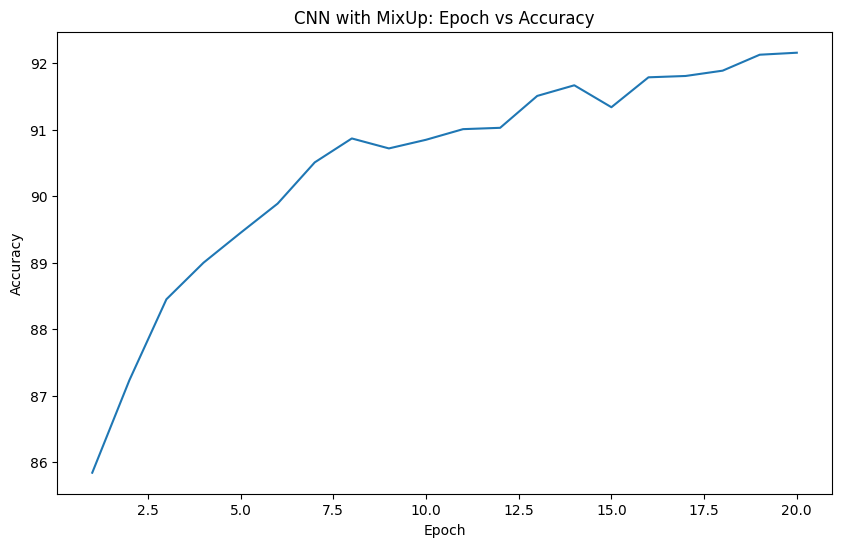

In [11]:
print(accuracies)
epochs = list(range(1, len(accuracies) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, linestyle='-')
plt.title('CNN with MixUp: Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Final Accuracy for MixUp CNN: 92.16%